In [7]:
!pip install -r requirements.txt

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import time
from kneed import KneeLocator


import os
import warnings

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['LOKY_MAX_CPU_COUNT'] = '1' 
warnings.filterwarnings('ignore')

In [11]:
# Load Data & Preprocessing
# Read CSV
df = pd.read_csv('Mall_Customers.csv')

# Male/Female -> 0/1
le = LabelEncoder()
df['Genre_Code'] = le.fit_transform(df['Genre'])

target = 'Spending Score (1-100)'
feats_to_compare = ['Genre_Code', 'Age', 'Annual Income (k$)']
all_feats = feats_to_compare + [target]

scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(df[all_feats])

Feature              | Best K | Time (s)  
---------------------------------------------
Genre_Code           | 4      | 0.06658
Age                  | 3      | 0.06344
Annual Income (k$)   | 5      | 0.08548


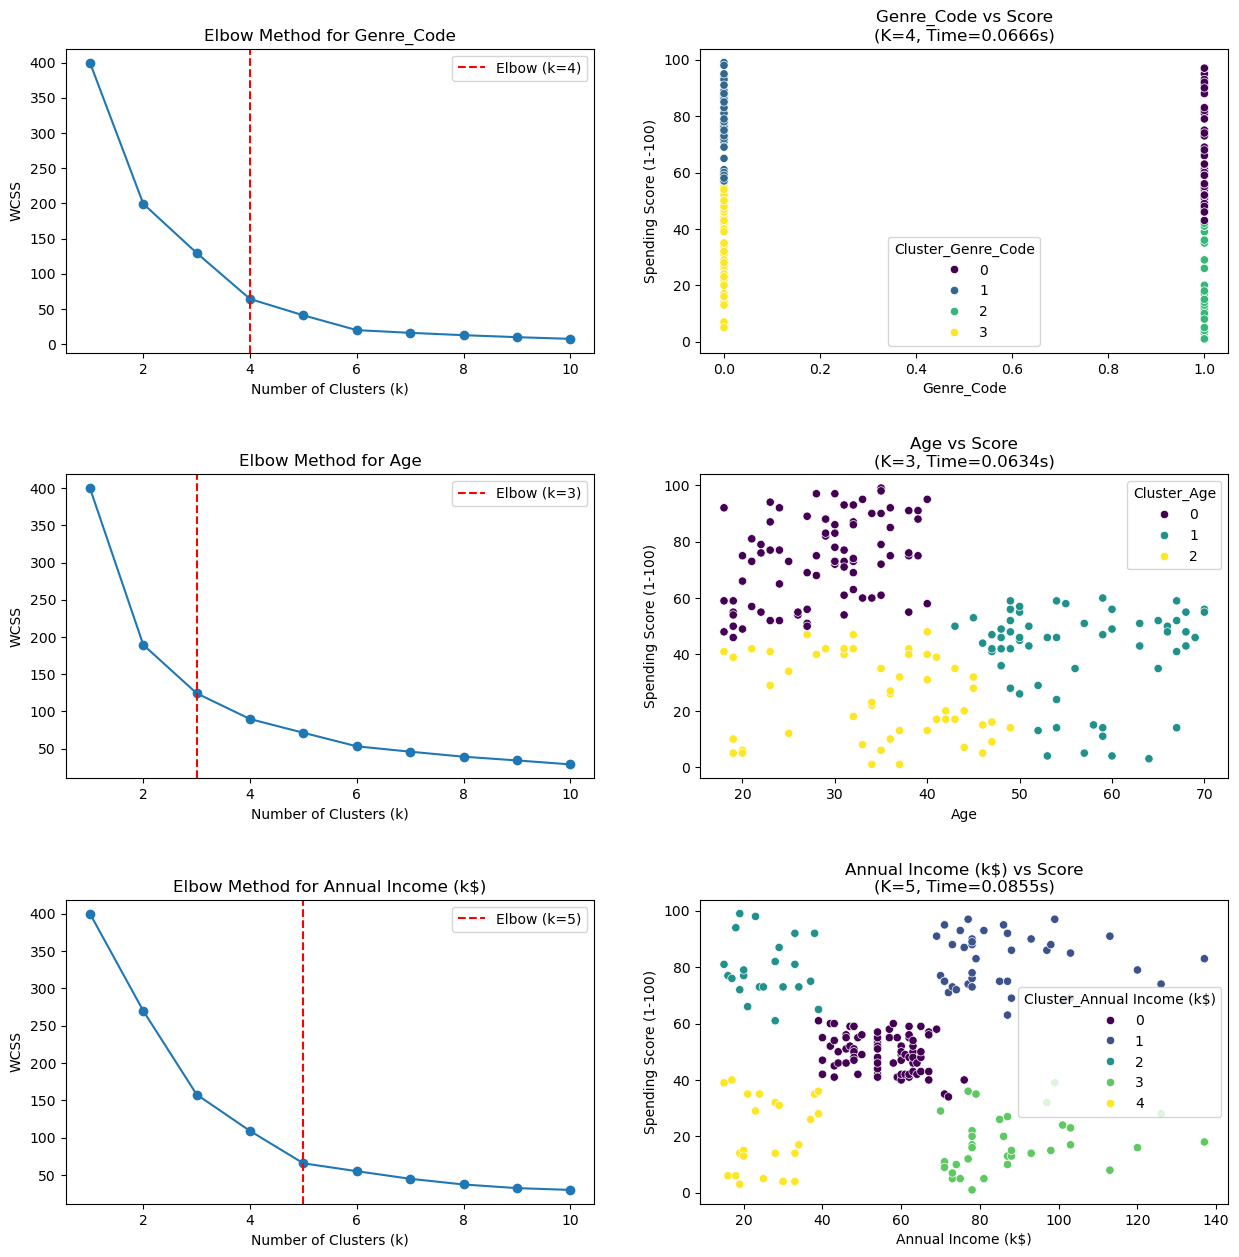

In [17]:
#K-Means with KneeLocator & Visualization
fig, axes = plt.subplots(len(feats_to_compare), 2, figsize=(15, 5 * len(feats_to_compare)))
plt.subplots_adjust(hspace=0.4)

print(f"{'Feature':<20} | {'Best K':<6} | {'Time (s)':<10}")
print("-" * 45)

for i, feat in enumerate(feats_to_compare):
    X_pair = df[[feat, target]].values
    X_pair_scaled = scaler.fit_transform(X_pair)
    
    wcss = []
    K_range = range(1, 11)
    for k in K_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
        kmeans.fit(X_pair_scaled)
        wcss.append(kmeans.inertia_)
    
    kl = KneeLocator(K_range, wcss, curve="convex", direction="decreasing")
    best_k = kl.elbow
    
    if best_k is None:
        best_k = 3 # Fallback default
        print(f"Warning: No elbow found for {feat}, using default 3")
    
    # time with the best K
    start = time.time()
    kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit(X_pair_scaled)
    elapsed = time.time() - start
    
    print(f"{feat:<20} | {best_k:<6} | {elapsed:.5f}")
    
    ax_elbow = axes[i, 0]
    ax_elbow.plot(K_range, wcss, marker='o')
    ax_elbow.axvline(x=best_k, color='r', linestyle='--', label=f'Elbow (k={best_k})')
    ax_elbow.set_title(f'Elbow Method for {feat}')
    ax_elbow.set_xlabel('Number of Clusters (k)')
    ax_elbow.set_ylabel('WCSS')
    ax_elbow.legend()
    
    ax_cluster = axes[i, 1]
    cluster_col = f'Cluster_{feat}'
    df[cluster_col] = kmeans.labels_
    sns.scatterplot(x=df[feat], y=df[target], hue=df[cluster_col], 
                    palette='viridis', ax=ax_cluster, legend='full')
    ax_cluster.set_title(f'{feat} vs Score\n(K={best_k}, Time={elapsed:.4f}s)')

plt.show()



Global Optimal K determined as 4
Global Clustering Execution Time: 0.8261 seconds


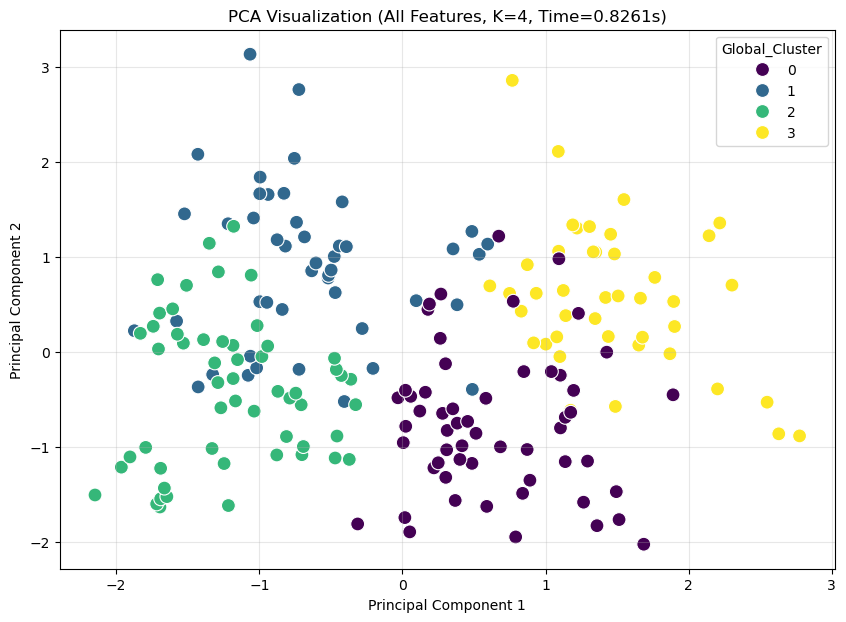

In [21]:
start_time = time.time()
# 1. find optimal K
wcss_global = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_all_scaled)
    wcss_global.append(kmeans.inertia_)

# 2. Determine K
kl_global = KneeLocator(K_range, wcss_global, curve="convex", direction="decreasing")
best_k_global = kl_global.elbow

print(f"\nGlobal Optimal K determined as {best_k_global}")

# 3. Final Clustering 
kmeans_global = KMeans(n_clusters=best_k_global, random_state=42, n_init=10)
global_labels = kmeans_global.fit_predict(X_all_scaled)

# 4. PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all_scaled)

df['PCA_1'] = X_pca[:, 0]
df['PCA_2'] = X_pca[:, 1]
df['Global_Cluster'] = global_labels

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Global Clustering Execution Time: {elapsed_time:.4f} seconds")

# 5. Visualization
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA_1', y='PCA_2', hue='Global_Cluster', data=df, palette='viridis', s=100)
plt.title(f'PCA Visualization (All Features, K={best_k_global}, Time={elapsed_time:.4f}s)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, alpha=0.3)
plt.show()